### 0. Install necessary packages

In [1]:
from preprocessing import Preprocess
from models import OgModel, AttModel, ModelWithLRP
from evaluation import EvaluateModel

import tensorflow as tf
from tensorflow.keras.models import Model
import innvestigate
import innvestigate.utils as iutils

2024-12-08 21:34:44.836552: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-08 21:34:44.840560: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-08 21:34:44.872792: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-08 21:34:44.872851: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-08 21:34:44.872874: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

### 1. Load the data

In [2]:
X_train, y_train, X_val, y_val, X_test, y_test, m, s = Preprocess(time_steps=5, start_year=2000, save=False)

--- Preprocessing ---
Remove low yield observations:  2
of years:  [1988. 2003.]
Full train data available:  (24311, 393)
Train data used: (10707, 397), starting from year 2000.
- Preprocessed data -
Train data (10707, 397, 1)
Validation data (560, 397, 1)
Test data (472, 397, 1)
Test data has mean 1.5 and std 0.99.



### 2. Set hyperparameters

In [3]:
Max_it = 4
learning_rate = 0.0006        # Learning rate

# Loss function parameters
alpha = 1                     # Weight of loss for final time step
beta = 1                      # Weight of loss for years before final time steps

# LSTM parameters
time_steps = 5                # Number of time steps for the RNN
num_units = 64                # Number of hidden units for LSTM cells
num_layers = 2                # Number of layers of LSTM cell
dropout = 0.3                 # Dropout rate

# Attention parameters
num_heads = 4
key_dim = 32

### 3.1 Original Model

In [4]:
ogmodel = OgModel(learning_rate, alpha, beta, time_steps, num_units, num_layers, dropout)
ogmodel.compile()

2024-12-08 21:27:30.906860: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-08 21:27:30.907580: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...



--- Model Architecture ---
 - CNN for Weather data - 
Output W-CNN: (None, 66)
 - CNN for Soil data - 
Output S-CNN: (None, 44)
 - Concatenate weather, soil and management data - 
W+S+M concatenated: (None, 124)
W+S+M after Dense: (None, 64)
 - LSTM for yield data - 
LSTM output: (None, 64)
 - Combine static and dynamic features - 
Combined: (None, 128)
Combined Dense: (None, 16)
Output: (None, 1) 

Total parameters: 112659


In [5]:
ogmodel.fit(X_train, y_train, X_val, y_val, epochs=3)

Epoch 1/3
335/335 [==============================] - 26s 40ms/step - loss: 0.7478 - val_loss: 0.3906 - lr: 6.0000e-04
Epoch 2/3
335/335 [==============================] - 11s 32ms/step - loss: 0.2987 - val_loss: 0.2772 - lr: 6.0000e-04
Epoch 3/3
335/335 [==============================] - 11s 34ms/step - loss: 0.2154 - val_loss: 0.2099 - lr: 6.0000e-04


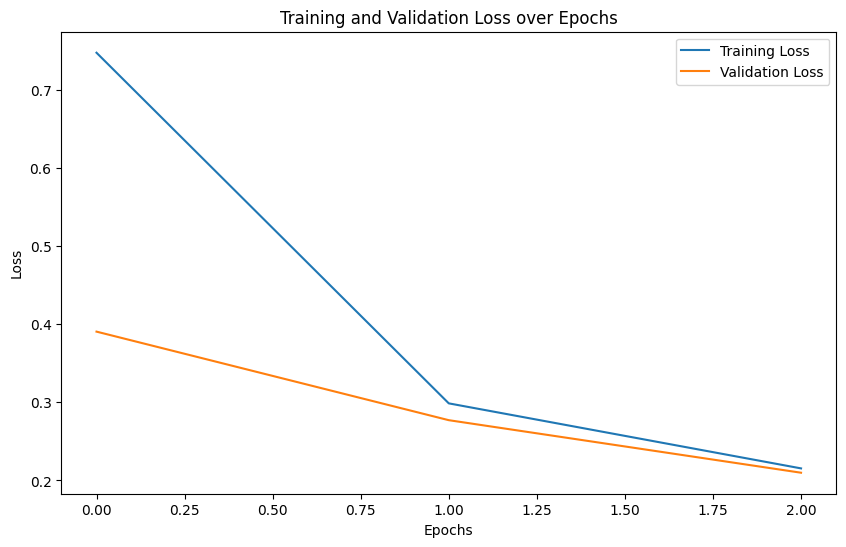

In [6]:
ogmodel.plot_training_history()

18/18 [==============================] - 0s 15ms/step
Training RMSE: 4.713005569401648
Validation RMSE: 5.3010230941183405 

Training MAE: 3.5299070362729883
Validation MAE: 4.064722483498709 

Training R²: 0.8128086905822419
Validation R²: 0.6822738734029477


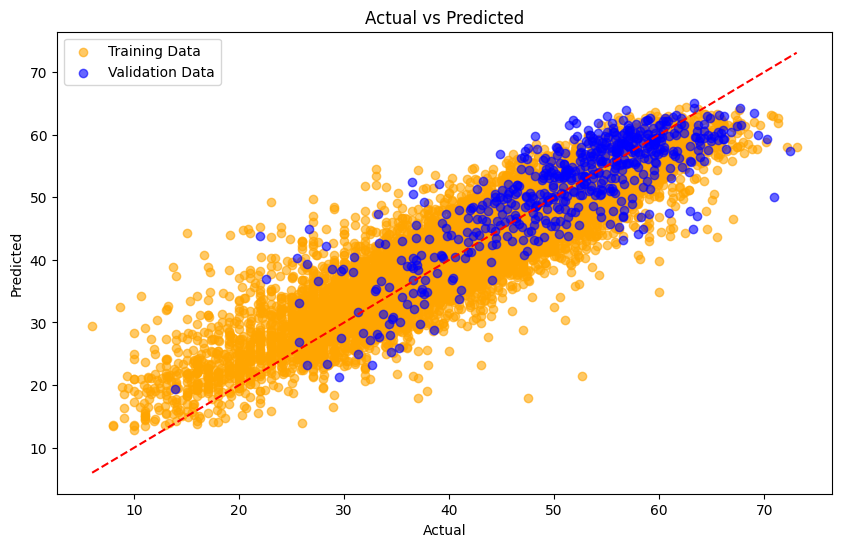

In [7]:
og_evaluator = EvaluateModel(ogmodel, X_train, y_train, X_val, y_val, s, m)
og_evaluator.evaluate()

### 3.2 Attention Model

In [8]:
attmodel = AttModel(learning_rate, alpha, beta, time_steps, num_units, num_layers, dropout, num_heads, key_dim)
attmodel.compile()


--- Model Architecture ---
 - CNN for Weather data - 
Input: (None, 52, 1)
Output: (None, 66)
 - CNN for Soil data - 
Input: (None, 6, 1)
Output: (None, 44)
 - Concatenate weather, soil and management data - 
W+S+M concatenated: (None, 124)
W+S+M after Dense: (None, 64)
 - LSTM for yield data - 
LSTM output: (None, 64)
 - Combine static and dynamic features - 
Combined: (None, 128)
Combined Dense: (None, 16)
Output: (None, 1) 

Total parameters: 113556


<Functional name=functional_35, built=True>

In [9]:
attmodel.fit(X_train, y_train, X_val, y_val, epochs=3)

Epoch 1/3
335/335 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 1.0867 - val_loss: 0.4953 - learning_rate: 6.0000e-04
Epoch 2/3
335/335 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.2988 - val_loss: 0.3251 - learning_rate: 6.0000e-04
Epoch 3/3
335/335 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.2074 - val_loss: 0.2977 - learning_rate: 6.0000e-04


<Functional name=functional_35, built=True>

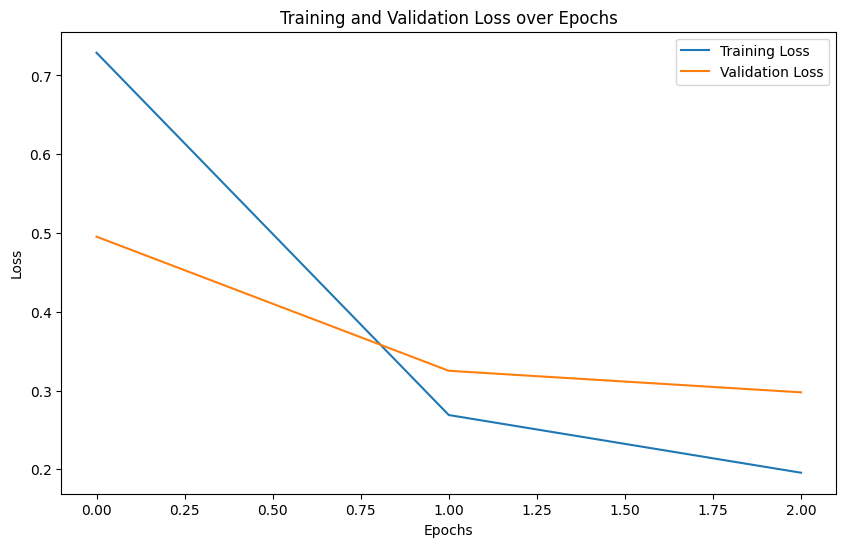

In [10]:
attmodel.plot_training_history()

335/335 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


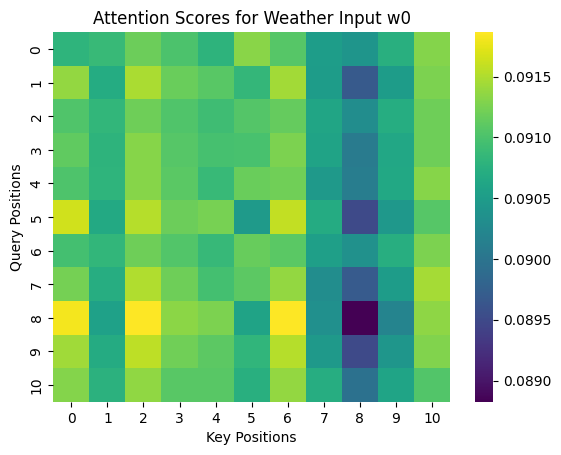

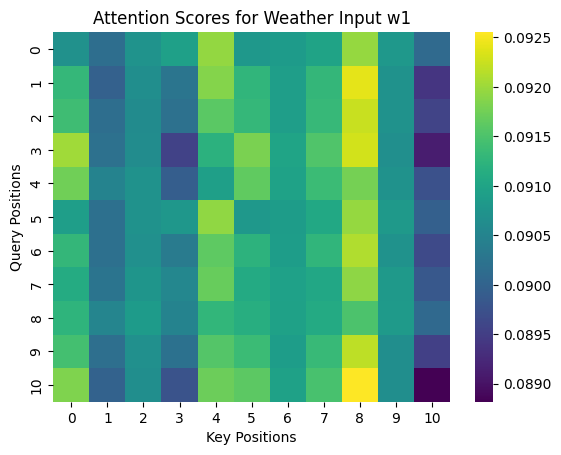

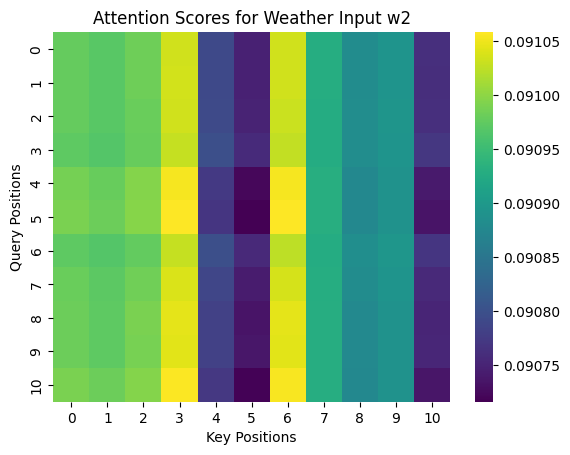

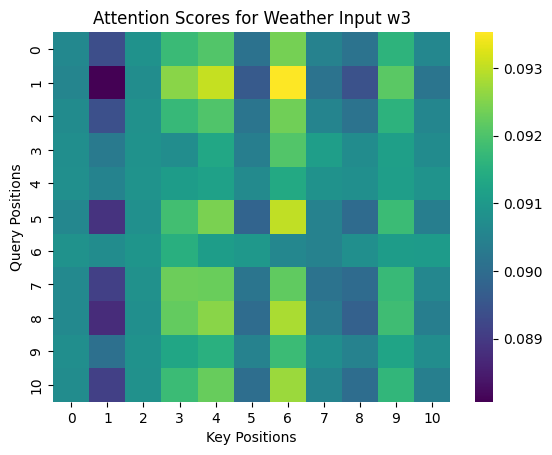

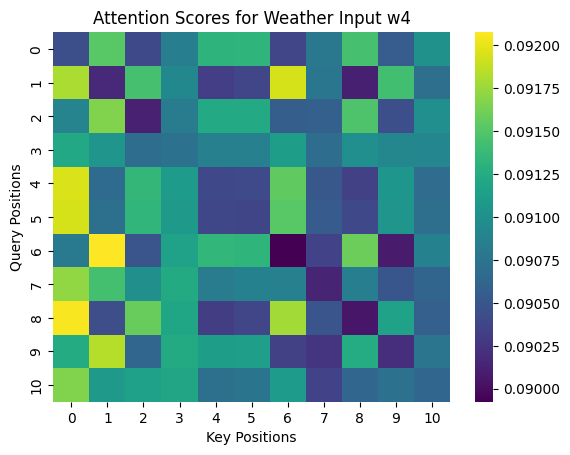

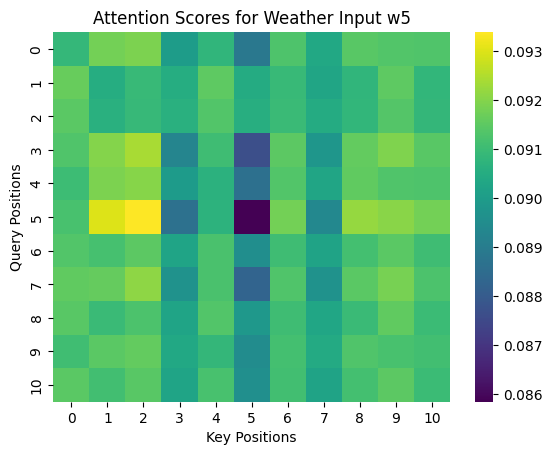

In [11]:
attmodel.visualize_attention(X_train, 'weather')

335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Training RMSE: 4.7623988948427
Validation RMSE: 7.264384194381387 

Training MAE: 3.5973155035258557
Validation MAE: 6.0124851711954275 

Training R²: 0.808864518998723
Validation R²: 0.4033341999900888


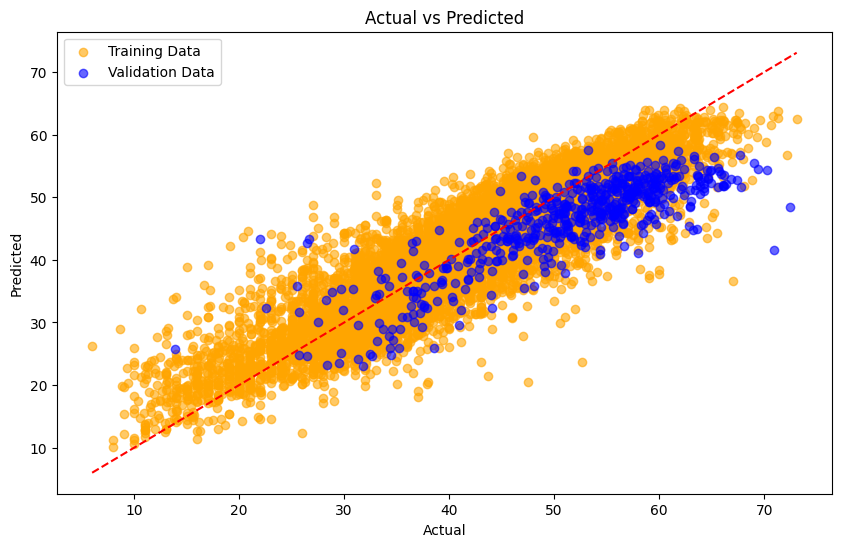

In [12]:
att_evaluator = EvaluateModel(attmodel, X_train, y_train, X_val, y_val, s, m)
att_evaluator.evaluate()

### 4. Explainability

In [4]:
# Build the model
LRPmodel = ModelWithLRP(learning_rate, alpha, beta, time_steps, num_units, num_layers, dropout)
LRPmodel.compile()

2024-12-08 21:34:57.457061: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-08 21:34:57.457658: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Total parameters: 112659


In [5]:
LRPmodel.fit(X_train, y_train, X_val, y_val, epochs=3)

Epoch 1/3
335/335 [==============================] - 25s 44ms/step - loss: 0.8901 - val_loss: 0.5716 - lr: 6.0000e-04
Epoch 2/3
335/335 [==============================] - 11s 33ms/step - loss: 0.4602 - val_loss: 0.3575 - lr: 6.0000e-04
Epoch 3/3
335/335 [==============================] - 12s 36ms/step - loss: 0.3254 - val_loss: 0.2722 - lr: 6.0000e-04


In [6]:
# Wrap the model with iNNvestigate for LRP
trained_model = LRPmodel.model
cnn_submodel = Model(inputs=trained_model.input, outputs=trained_model.get_layer('final_CNN_layer').output)

for original_layer, sub_layer in zip(trained_model.layers, cnn_submodel.layers):
    if original_layer.name == sub_layer.name:
        assert (original_layer.get_weights() == sub_layer.get_weights()), f"Weights do not match for layer {original_layer.name}"
print("Weights successfully transferred!")

Weights successfully transferred!


In [7]:
analyzer = innvestigate.create_analyzer("lrp.z", cnn_submodel)

relevance_scores = analyzer.analyze(X_val)

/home/jpubu/Master/Applied-Deep-Learning/Project/venv/lib/python3.10/site-packages/innvestigate/analyzer/base.py:124: UserWarning: LRP is only tested for convolutional neural networks.
Check triggered by layers: [<keras.src.engine.functional.Functional object at 0x7f210e0c2500>, <keras.src.engine.functional.Functional object at 0x7f210c748430>, <keras.src.engine.functional.Functional object at 0x7f210e0c10f0>, <keras.src.engine.functional.Functional object at 0x7f210c781600>, <keras.src.engine.functional.Functional object at 0x7f210c7a7730>, <keras.src.engine.functional.Functional object at 0x7f210c7720e0>, <keras.src.engine.functional.Functional object at 0x7f210c7f0220>, <keras.src.engine.functional.Functional object at 0x7f210c301060>, <keras.src.engine.functional.Functional object at 0x7f210c3021a0>, <keras.src.engine.functional.Functional object at 0x7f210c315000>, <keras.src.engine.functional.Functional object at 0x7f210c339ed0>, <keras.src.engine.functional.Functional object at 

NotImplementedError: 

In [9]:
for layer in cnn_submodel.layers:
    print(layer.name, layer.__class__.__name__)


w0 InputLayer
w1 InputLayer
w2 InputLayer
w3 InputLayer
w4 InputLayer
w5 InputLayer
s0 InputLayer
s1 InputLayer
s2 InputLayer
s3 InputLayer
s4 InputLayer
s5 InputLayer
s6 InputLayer
s7 InputLayer
s8 InputLayer
s9 InputLayer
s10 InputLayer
model Functional
model_1 Functional
model_2 Functional
model_3 Functional
model_4 Functional
model_5 Functional
model_6 Functional
model_7 Functional
model_8 Functional
model_9 Functional
model_10 Functional
model_11 Functional
model_12 Functional
model_13 Functional
model_14 Functional
model_15 Functional
model_16 Functional
p InputLayer
concatenate Concatenate
concatenate_1 Concatenate
reshape Reshape
concatenate_2 Concatenate
avg_yield InputLayer
final_CNN_layer Dense


In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Assume model_x is a submodel within cnn_submodel
def flatten_model(parent_model, submodel_name):
    submodel = parent_model.get_layer(submodel_name)
    inputs = parent_model.input
    x = submodel(inputs)
    return Model(inputs=inputs, outputs=x)

# Replace the nested submodel with its flattened equivalent


In [ ]:
flattened_submodel = flatten_model(cnn_submodel, "model")
#
#
# TODO: DEFINE THE MODEL FLAT INSTEAD OF FLATTEN AFTERWARDS
#


for layer in flattened_submodel.layers:
    print(layer.name, layer.__class__.__name__)

/home/jpubu/Master/Applied-Deep-Learning/Project/venv/lib/python3.10/site-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['w0', 'w1', 'w2', 'w3', 'w4', 'w5', 's0', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 'p', 'avg_yield'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


ValueError: Exception encountered when calling layer "model" (type Functional).

Input 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 112, but received input with shape (None, 16)

Call arguments received by layer "model" (type Functional):
  • inputs={'w0': 'tf.Tensor(shape=(None, 52, 1), dtype=float32)', 'w1': 'tf.Tensor(shape=(None, 52, 1), dtype=float32)', 'w2': 'tf.Tensor(shape=(None, 52, 1), dtype=float32)', 'w3': 'tf.Tensor(shape=(None, 52, 1), dtype=float32)', 'w4': 'tf.Tensor(shape=(None, 52, 1), dtype=float32)', 'w5': 'tf.Tensor(shape=(None, 52, 1), dtype=float32)', 's0': 'tf.Tensor(shape=(None, 6, 1), dtype=float32)', 's1': 'tf.Tensor(shape=(None, 6, 1), dtype=float32)', 's2': 'tf.Tensor(shape=(None, 6, 1), dtype=float32)', 's3': 'tf.Tensor(shape=(None, 6, 1), dtype=float32)', 's4': 'tf.Tensor(shape=(None, 6, 1), dtype=float32)', 's5': 'tf.Tensor(shape=(None, 6, 1), dtype=float32)', 's6': 'tf.Tensor(shape=(None, 6, 1), dtype=float32)', 's7': 'tf.Tensor(shape=(None, 6, 1), dtype=float32)', 's8': 'tf.Tensor(shape=(None, 6, 1), dtype=float32)', 's9': 'tf.Tensor(shape=(None, 6, 1), dtype=float32)', 's10': 'tf.Tensor(shape=(None, 6, 1), dtype=float32)', 'p': 'tf.Tensor(shape=(None, 14, 1), dtype=float32)', 'avg_yield': 'tf.Tensor(shape=(None, 5, 1), dtype=float32)'}
  • training=None
  • mask=None

In [13]:
import shap
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_val)
shap.summary_plot(shap_values, X_val)

ModuleNotFoundError: No module named 'shap'